# Sprint 6. Análisis Exploratorio de Datos

## Proyecto: videojuegos

### Paso 1. Estudia la información general 

In [204]:
#importar librerías
import pandas as pd
import numpy as np
import sidetable as stb
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st 

#Cargar DF
df = pd.read_csv(r"C:\Users\Admin\OneDrive\Escritorio\Triple Ten\Sprint 6\games.csv")

In [205]:
#información del df
df.info()
#duplicados 
duplicados = df[df.duplicated()]
print(f'La cantidad de registros duplicados es de {len(duplicados)}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
La cantidad de registros duplicados es de 0


In [206]:
#muestra del df
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


## Paso 2. Prepara los datos

### 2.1 Manejo de dtypes

In [207]:
#reemplazo de los nombres de las columnas en minúsculas
df.columns = df.columns.str.lower()

In [208]:
#convierte los datos en los tipos necesarios
df['name'] = df['name'].astype('string') #este campo solo contiene valores str
df['platform'] = df['platform'].astype('string') #este campo solo contiene valores str
df['year_of_release'] = df['year_of_release'].fillna(0).astype('int')#este campo es mejor formatearlo como fecha
df['genre'] = df['genre'].astype('string') #este campo solo contiene valores str
df['rating'] = df['rating'].astype('string') #este campo solo contiene valores str

In [209]:
#campos con el valor TBD
df['user_score'] = df['user_score'].replace('tbd',np.nan) #se remplazan los valores to be determined con NAN
df['user_score'] = df['user_score'].astype('float64') #una vez manjeados los valores tbd se cambia a float

In [210]:
#validación
df.info()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  string 
 1   platform         16715 non-null  string 
 2   year_of_release  16715 non-null  int64  
 3   genre            16713 non-null  string 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   string 
dtypes: float64(6), int64(1), string(4)
memory usage: 1.4 MB
                       name platform  year_of_release         genre  na_sales  \
0                Wii Sports      Wii             2006        Sports     41.36   
1         Super Mario Bros.      NES             1985      Platform   

**2.2 Manejo de valores nulos**

In [211]:
#porcentaje de valores nulos con sidetable
df.stb.missing()

,missing,total,percent
user_score,9125,16715,54.591684
critic_score,8578,16715,51.319174
rating,6766,16715,40.478612
name,2,16715,0.011965
genre,2,16715,0.011965
year_of_release,0,16715,0.000000
platform,0,16715,0.000000
jp_sales,0,16715,0.000000
eu_sales,0,16715,0.000000
na_sales,0,16715,0.000000


**El orden para manejear los valores nulos sera tomado en cuenta por los campos que contengan mas valores vacíos.**

Para year_of_release

In [212]:
#los valores con 0 se rellenarán con el año promedio tomando en cuenta los años activos de las plataformas.
df['platform'].unique()

<StringArray>
[ 'Wii',  'NES',   'GB',   'DS', 'X360',  'PS3',  'PS2', 'SNES',  'GBA',
  'PS4',  '3DS',  'N64',   'PS',   'XB',   'PC', '2600',  'PSP', 'XOne',
 'WiiU',   'GC',  'GEN',   'DC',  'PSV',  'SAT',  'SCD',   'WS',   'NG',
 'TG16',  '3DO',   'GG', 'PCFX']
Length: 31, dtype: string

In [213]:
#Para PC se utilizará el último año del que se tenga registro en la base
df['year_of_release'].max()

np.int64(2016)


Para completar los valores nulos en el año de lanzamiento, se utilizará el promedio de los años activos de las consolas, considerando el año en que fueron lanzadas y el año en que dejaron de recibir nuevos videojuegos.

In [214]:
# Diccionario con años de lanzamiento y descontinuación por plataforma
platform_years = {
    'Wii': (2006, 2013),
    'NES': (1983, 1995),
    'GB': (1989, 2003),
    'DS': (2004, 2014),
    'X360': (2005, 2016),
    'PS3': (2006, 2017),
    'PS2': (2000, 2013),
    'SNES': (1990, 2003),
    'GBA': (2001, 2008),
    'PS4': (2013, 2020),  # PS4 aún no está oficialmente descontinuada, se asumió una fecha tentativa.
    '3DS': (2011, 2020),
    'N64': (1996, 2002),
    'PS': (1994, 2006),
    'XB': (2001, 2009),
    'PC': (1981, 2016),  # PC sigue vigente, colocaremos `None` para plataformas no descontinuadas.
    '2600': (1977, 1992),
    'PSP': (2004, 2014),
    'XOne': (2013, 2020),  # Fecha tentativa para Xbox One.
    'WiiU': (2012, 2017),
    'GC': (2001, 2007),
    'GEN': (1988, 1997),
    'DC': (1999, 2001),
    'PSV': (2011, 2019),
    'SAT': (1994, 2000),
    'SCD': (1991, 1996),
    'WS': (1999, 2003),
    'NG': (1990, 1997),
    'TG16': (1987, 1999),
    '3DO': (1993, 1996),
    'GG': (1990, 1997),
    'PCFX': (1994, 1998)
}

In [215]:
# Crear un DataFrame a partir del diccionario
platform_df = pd.DataFrame.from_dict(platform_years, orient='index', columns=['launch_year', 'discontinue_year']).reset_index()
platform_df.columns= ['platform','launch_year', 'discontinue_year']

In [216]:
#info 
platform_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   platform          31 non-null     object
 1   launch_year       31 non-null     int64 
 2   discontinue_year  31 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 876.0+ bytes


In [217]:
# Calcular la fecha promedio
platform_df['average_year'] = (platform_df['launch_year'] + platform_df['discontinue_year']) / 2
#conversion de dtypes a float
platform_df['launch_year']

#conversion de float a int
platform_df['discontinue_year'] = platform_df['discontinue_year'].astype('int')
platform_df['average_year'] = platform_df['average_year'].astype('int')
#validación
platform_df.head()

,platform,launch_year,discontinue_year,average_year
0,Wii,2006,2013,2009
1,NES,1983,1995,1989
2,GB,1989,2003,1996
3,DS,2004,2014,2009
4,X360,2005,2016,2010


In [218]:
#unión de DataFrames
df = df.merge(platform_df[['platform','average_year']], on = 'platform', how = 'left')

df["year_of_release"] = df.apply(
    lambda row: row["average_year"] if row["year_of_release"] == 0 else row["year_of_release"],
    axis=1
)
#validación 
df[~df['year_of_release']== 0]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,average_year


In [219]:
df['year_of_release'].unique()

array([2006, 1985, 2008, 2009, 1996, 1989, 1984, 2005, 1999, 2007, 2010,
       2013, 2004, 1990, 1988, 2002, 2001, 2011, 1998, 2015, 2012, 2014,
       1992, 1997, 1993, 1994, 1982, 2016, 2003, 1986, 2000, 1995, 1991,
       1981, 1987, 1980, 1983])

Para user_score

In [220]:
#calculamos la mediana de 'user_score' y rellenamos con ese valor.
media_user = df['user_score'].mean()
df['user_score'] = df['user_score'].fillna(media_user)
media_user

np.float64(7.125046113306982)

Para critic_score

In [221]:
#calculamos la mediana de 'critic_score' y rellenamos con ese valor.
media_critica = df['critic_score'].mean()
df['critic_score'] = df['critic_score'].fillna(media_critica)

Para rating

In [222]:
#comprobación de recuento de valores
df['rating'].value_counts()

rating
E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: count, dtype: Int64

In [223]:
#se tratan los valores nulos con la moda, siendo la clasificación "E" como el valor que más se repite.
df['rating'] = df['rating'].fillna('E')
#validación
df['rating'].isna().sum()

np.int64(0)

Para name y genre

In [224]:
#en este caso, ambos campos comparten los mismos registros vacíos
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,average_year
659,<NA>,GEN,1993,<NA>,1.78,0.53,0.00,0.08,68.967679,7.125046,E,1992
14244,<NA>,GEN,1993,<NA>,0.00,0.00,0.03,0.00,68.967679,7.125046,E,1992


In [225]:
#para name
df['name'] = df['name'].fillna('Unknown')
#para genre 
df['genre'] = df['genre'].fillna('Unknown')
#validación
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,average_year


In [226]:
#validación de valores nulos
df.isna().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
average_year       0
dtype: int64

# Paso 3. Analiza los datos



## ¿Cuántos juegos se lanzaron por año?

In [227]:
#query
juegos_por_año = df.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count').reset_index()
#renombarar columnas
juegos_por_año.columns = ['year_of_release','count']
#ordenamiento de valores
juegos_por_año.sort_values(by= 'count').head()
#juegos_por_año.sort_values(by = 'count', ascending= True)

,year_of_release,count
0,1980,9
5,1985,14
8,1988,15
7,1987,16
10,1990,16


In [228]:
#validación
juegos_por_año.head()

,year_of_release,count
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,31


Observa cómo varían las ventas de una plataforma a otra

In [229]:
#creación de campo ventas totales
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
#validación
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,average_year,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.000000,8.000000,E,2009,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,68.967679,7.125046,E,1989,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.000000,8.300000,E,2009,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.000000,8.000000,E,2009,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,68.967679,7.125046,E,1996,31.38


In [230]:
#query para comparar las ventas por plataforma
ventas_por_plataforma = df.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum')
#ordenar de forma descendente 
ventas_por_plataforma_ordenada = ventas_por_plataforma.sort_values(by = 'total_sales', ascending = False).reset_index()
#validación
plataformas_con_mas_ventas = ventas_por_plataforma_ordenada.head()
plataformas_con_mas_ventas


,platform,total_sales
0,PS2,1255.77
1,X360,971.42
2,PS3,939.65
3,Wii,907.51
4,DS,806.12


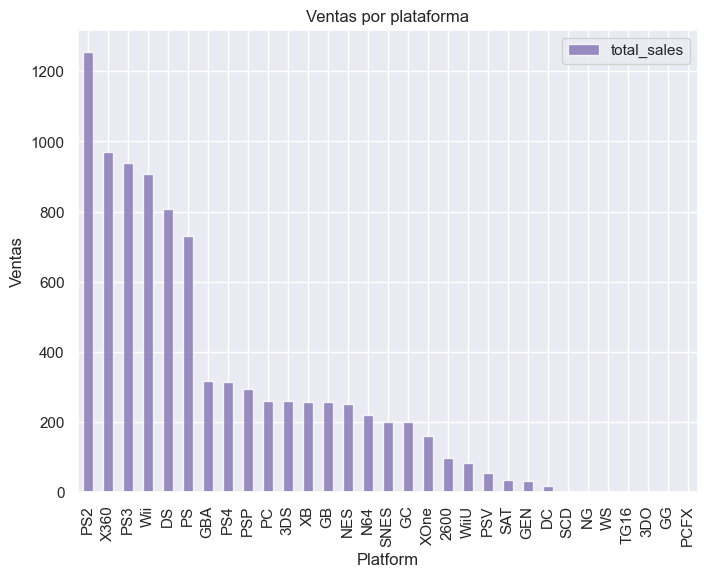

In [252]:
#gráfico de ventas por plataforma
ventas_por_plataforma_ordenada.plot(
    x= 'platform',
    figsize= (8,6),
    kind= 'bar',
    xlabel= 'Platform',
    ylabel= 'Ventas',
    title= 'Ventas por plataforma',
    color = 'm',
    alpha = 0.8
)
plt.show()

Conclusiones:
La gráfica evidencia que la PS2 lidera ampliamente las ventas totales, consolidándose como la consola más exitosa de todos los tiempos. Las plataformas como X360 y PS3 también destacan, reflejando el auge de la industria en su generación. Sin embargo, se observa un declive en las plataformas más antiguas como NES y SNES, mientras que algunas recientes como PS4 y XOne muestran ventas prometedoras pero aún no alcanzan el nivel de sus predecesoras. 

**Elige las plataformas con las mayores ventas totales y construye una distribución basada en los datos de cada año.**

Plataformas con las mayores ventas

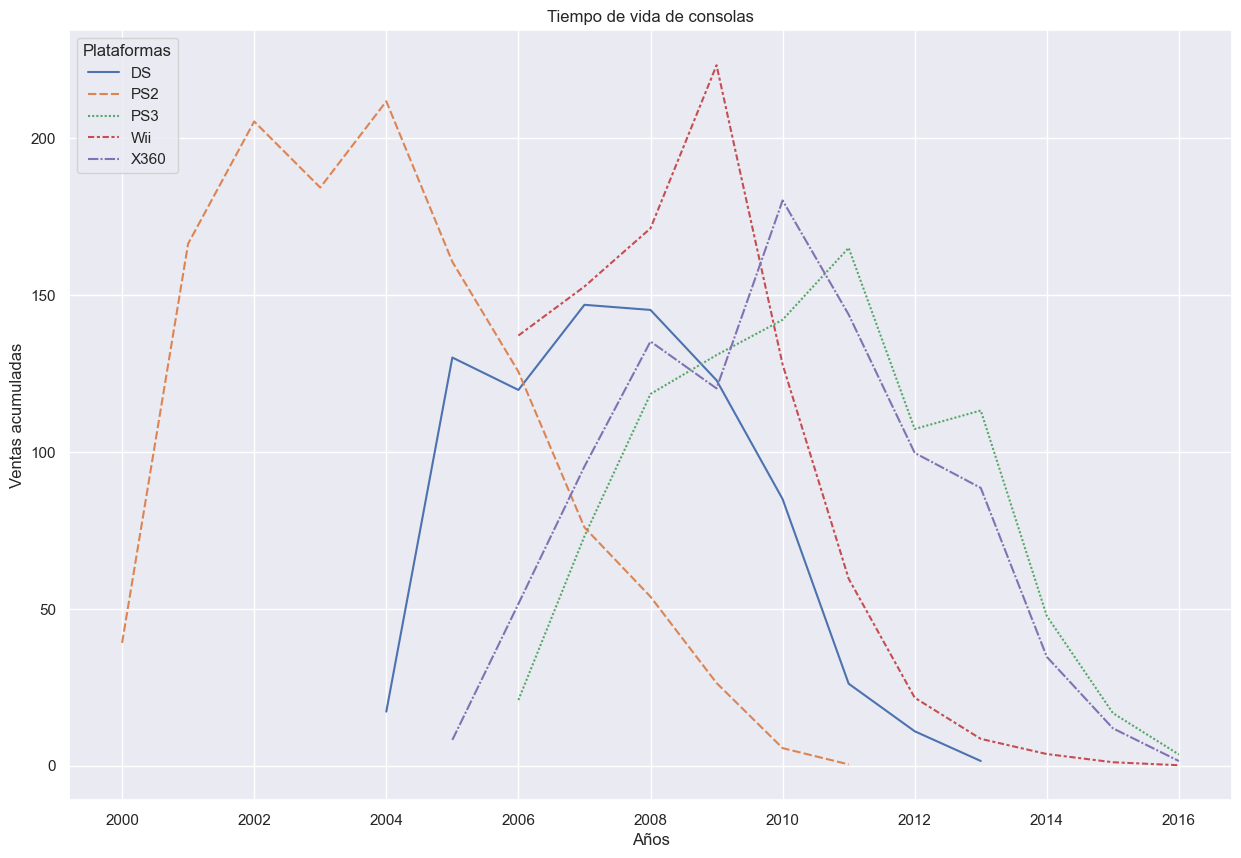

In [232]:
# Filtrar los datos para las plataformas deseadas
plataformas_deseadas = ['PS2', 'X360', 'PS3', 'Wii', 'DS']
df_filtrado = df[(df['platform'].isin(plataformas_deseadas)) & (df['year_of_release']>= 2000)]

# Crear el dataframe pivot
df_top5 = df_filtrado.pivot_table(
    index='year_of_release', 
    columns='platform', 
    values='total_sales', 
    aggfunc='sum'
)

# Configurar el tamaño de la figura
sns.set(rc={"figure.figsize": (15, 10)})

# Crear el gráfico de línea
sns.lineplot(data=df_top5)
plt.title('Tiempo de vida de consolas')
plt.xlabel('Años')
plt.ylabel('Ventas acumuladas')
plt.legend(title='Plataformas', loc='upper left')
plt.show()

Podemos observar que las consolas más vendidas tuvieron sus picos en ventas desde 2004 hasta 2011, después de ese año han decrecido. 

**Ciclo de vida de todas las plataformas** 

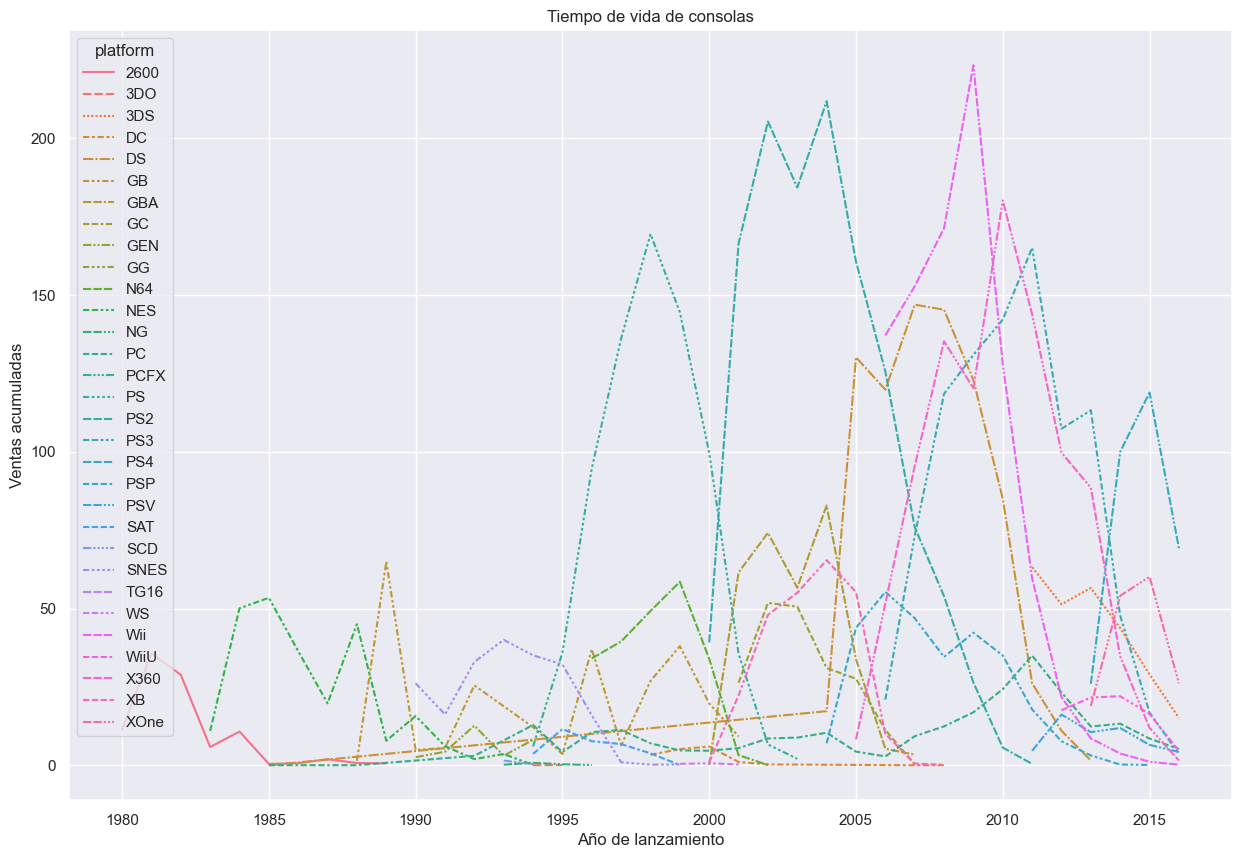

In [233]:
# Crear el dataframe pivot
df_tiempo_de_vida = df.pivot_table(
    index='year_of_release', 
    columns='platform', 
    values='total_sales', 
    aggfunc='sum'
)

# Configurar el tamaño de la figura
sns.lineplot(data = df_tiempo_de_vida)
sns.set(rc={"figure.figsize": (15, 10)})

# Configurar el título y etiquetas de los ejes
plt.title('Tiempo de vida de consolas')
plt.xlabel('Año de lanzamiento')
plt.ylabel('Ventas acumuladas')
plt.show()

En este gráfico observamos que el PS4 y el XOne, tuvieron un pico en 2015 coocandose como las pataformas mas rentables, sin embargo se observa una caída en los datos después de ese año. 

**Busca las plataformas que solían ser populares pero que ahora no tienen ventas. ¿Cuánto tardan generalmente las nuevas plataformas en aparecer y las antiguas en desaparecer?**

In [234]:
# Agrupar por plataforma para obtener el rango de años
platform_lifetime = df.groupby('platform')['year_of_release'].agg(['min', 'max'])

# Calcular duración (desaparición - aparición)
platform_lifetime['duration'] = platform_lifetime['max'] - platform_lifetime['min']

# Duración promedio
average_duration = platform_lifetime['duration'].mean()
print(f"Duración promedio de las plataformas: {average_duration:.2f} años")

Duración promedio de las plataformas: 7.61 años



Plataformas icónicas como la PS1, PS2 y DS, que surgieron en la primera década de los 2000, ya no generan ventas, pero dejaron una huella significativa como algunas de las consolas más exitosas de esa época. Sin embargo, el rendimiento de estas plataformas tiende a disminuir con el tiempo, especialmente cuando aparecen sucesoras más avanzadas, como ha sucedido con las generaciones de PlayStation. Este comportamiento refleja el ciclo de vida típico de las consolas, que generalmente dura alrededor de 8 años.

**¿Qué plataformas son líderes en ventas? ¿Cuáles crecen y cuáles se reducen? Elige varias plataformas potencialmente rentables**


Las consolas que más venden son PS2, Xbox 360, PS3, Wii, DS y PS.

Los datos disponibles hasta 2015 muestran una disminución en las ventas de todas las plataformas, sin que se observe un crecimiento significativo. Esto podría indicar que la empresa dejó de registrar las ventas de consolas después de este año.


**Crea un diagrama de caja para las ventas globales de todos los juegos, desglosados por plataforma. ¿Son significativas las diferencias en las ventas? ¿Qué sucede con las ventas promedio en varias plataformas? Describe tus hallazgos**

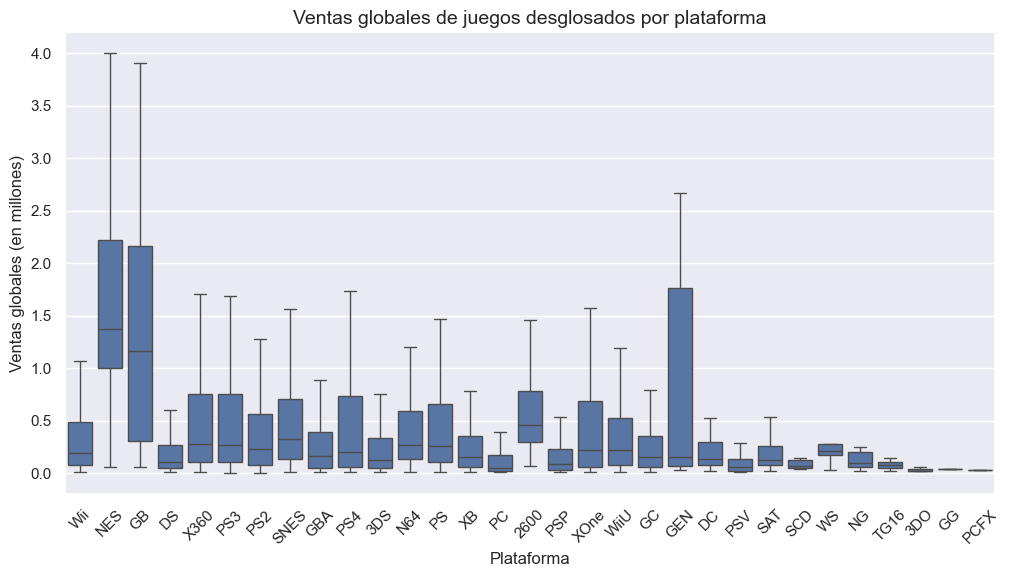

In [235]:
# gráfico 'platform' x 'global_sales'

# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Crear el diagrama de caja
sns.boxplot(data=df, x='platform', y='total_sales', showfliers=False)  # Excluir outliers para mejor visualización

# Personalizar
plt.title('Ventas globales de juegos desglosados por plataforma', fontsize=14)
plt.xlabel('Plataforma', fontsize=12)
plt.ylabel('Ventas globales (en millones)', fontsize=12)
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

Las plataformas NES y GB tienen ventas más dispersas, pero sus medianas están por encima del millón de ventas, lo que sugiere que muchos de sus juegos lograron un buen desempeño comercial. Por otro lado, GEN muestra una gran dispersión en las ventas, pero su mediana baja indica que la mayoría de los juegos no alcanzaron el millón de ventas, a pesar de algunos éxitos aislados. En general, como se observa en este gráfico, la mayoría de los videojuegos en las plataformas no superaron el medio millón de unidades vendidas, reflejando la naturaleza variable de las ventas en la industria de los videojuegos.

**Mira cómo las reseñas de usuarios y profesionales afectan las ventas de una plataforma popular (tu elección). Crea un gráfico de dispersión y calcula la correlación entre las reseñas y las ventas. Saca conclusiones.**

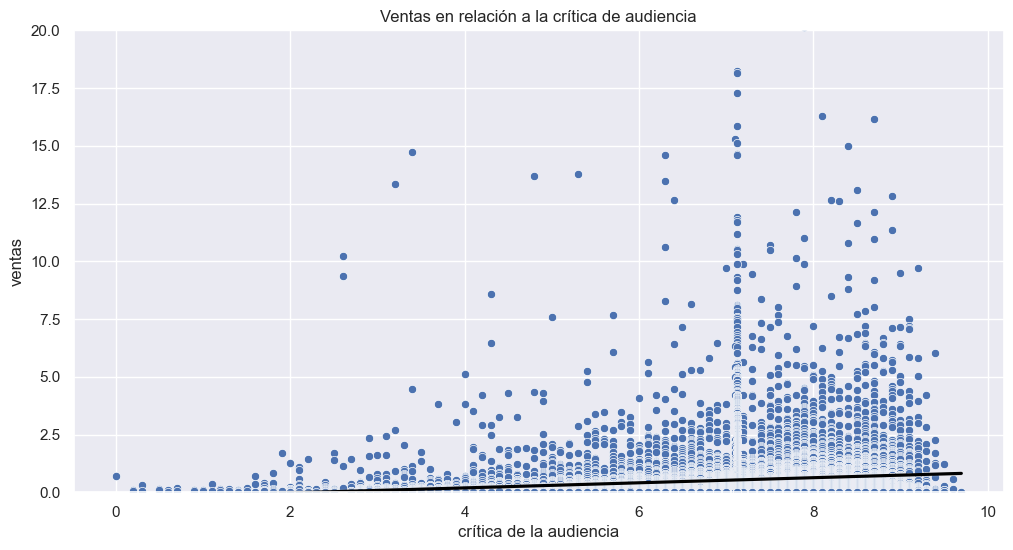

In [236]:
#creación de gráfico de dispersión
plt.figure(figsize=(12,6))
sns.scatterplot(data = df, x='user_score', y='total_sales')
sns.set_theme(style='darkgrid')


plt.title('Ventas en relación a la crítica de audiencia')
# Añadir línea de tendencia
sns.regplot(data=df, x='user_score', y='total_sales', scatter=False, color='black')
plt.ylabel('ventas')
plt.xlabel('crítica de la audiencia')
plt.ylim(0,20)
plt.show()

Se observa un ligera correlación positiva entre las ventas y la crítica de los usuarios.Lo que sugiere que un juego con crítica positiva de los usuarios suele vender más.

**Teniendo en cuenta tus conclusiones compara las ventas de los mismos juegos en otras plataformas.**

In [237]:
#super mario bros

mario_bros = df.query('name == "Super Mario Bros."')
mario_bros

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,average_year,total_sales
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,68.967679,7.125046,E,1989,40.24
201,Super Mario Bros.,GB,1999,Platform,3.40,1.30,0.15,0.22,68.967679,7.125046,E,1996,5.07


In [238]:
#Call of Duty: Modern Warfare 3
call_of_duty = df.query("name == 'Call of Duty: Modern Warfare 3'")
call_of_duty

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,average_year,total_sales
29,Call of Duty: Modern Warfare 3,X360,2011,Shooter,9.04,4.24,0.13,1.32,88.0,3.4,M,2010,14.73
37,Call of Duty: Modern Warfare 3,PS3,2011,Shooter,5.54,5.73,0.49,1.57,88.0,3.2,M,2011,13.33
1040,Call of Duty: Modern Warfare 3,PC,2011,Shooter,0.41,0.98,0.00,0.32,78.0,2.5,M,1998,1.71
2500,Call of Duty: Modern Warfare 3,Wii,2011,Shooter,0.55,0.20,0.00,0.08,70.0,1.8,M,2009,0.83


In [239]:
#Grand Theft Auto V
gta_v = df.query("name == 'Grand Theft Auto V'")
gta_v


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,average_year,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,2011,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,2010,16.27
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,2016,12.62
165,Grand Theft Auto V,XOne,2014,Action,2.81,2.19,0.00,0.47,97.0,7.9,M,2016,5.47
1730,Grand Theft Auto V,PC,2015,Action,0.39,0.69,0.00,0.09,96.0,7.9,M,1998,1.17


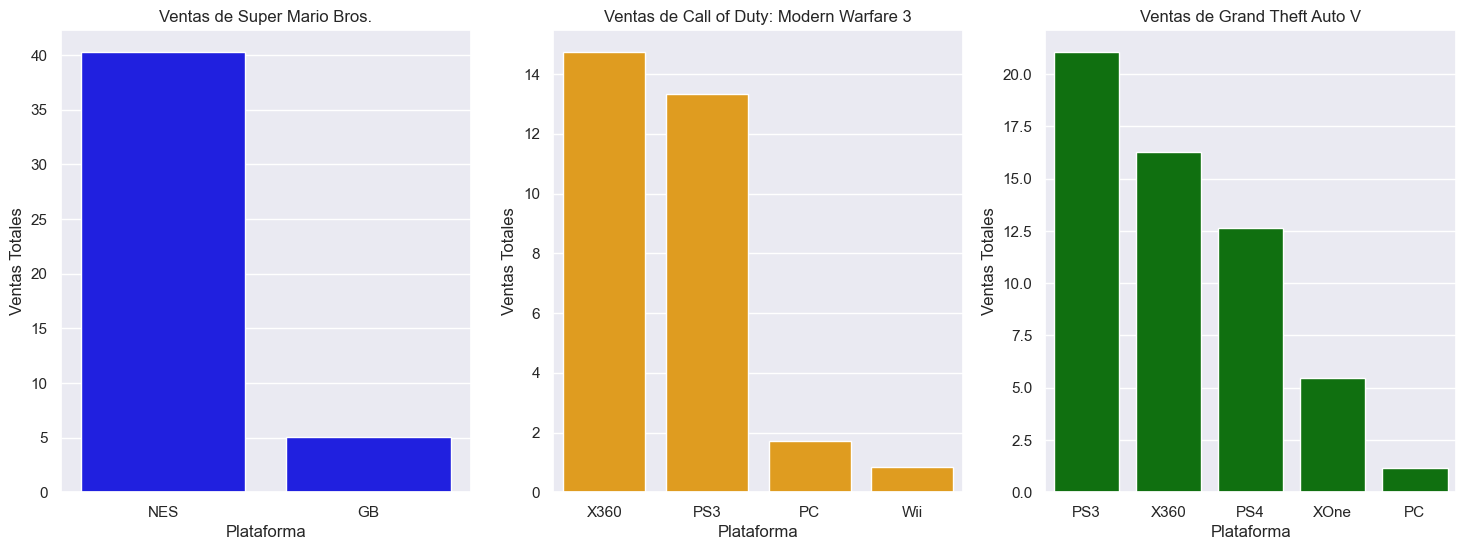

In [240]:
#comparación de ventas de los juegos más vendidos en distintas plataformas
#subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# graficar las ventas de 'Super Mario Bros.'
sns.barplot(ax=axes[0], data=mario_bros, x='platform', y='total_sales', color='Blue')
axes[0].set_title('Ventas de Super Mario Bros.')
axes[0].set_xlabel('Plataforma')
axes[0].set_ylabel('Ventas Totales')

# graficar las ventas de 'Call of Duty: Modern Warfare 3'
sns.barplot(ax=axes[1], data=call_of_duty, x='platform', y='total_sales', color='Orange')
axes[1].set_title('Ventas de Call of Duty: Modern Warfare 3')
axes[1].set_xlabel('Plataforma')
axes[1].set_ylabel('Ventas Totales')

# graficar las ventas de 'Grand Theft Auto V'
sns.barplot(ax=axes[2], data=gta_v, x='platform', y='total_sales', color='Green')
axes[2].set_title('Ventas de Grand Theft Auto V')
axes[2].set_xlabel('Plataforma')
axes[2].set_ylabel('Ventas Totales')

plt.show()

Las plataformas de los juegos más vendidos varían según si son exclusivos de una consola, como sucede con los juegos de Nintendo. En el caso de los juegos no exclusivos, se observa que Xbox 360 y PS3 son las plataformas más utilizadas.

**Echa un vistazo a la distribución general de los juegos por género. ¿Qué se puede decir de los géneros más rentables? ¿Puedes generalizar acerca de los géneros con ventas altas y bajas?**

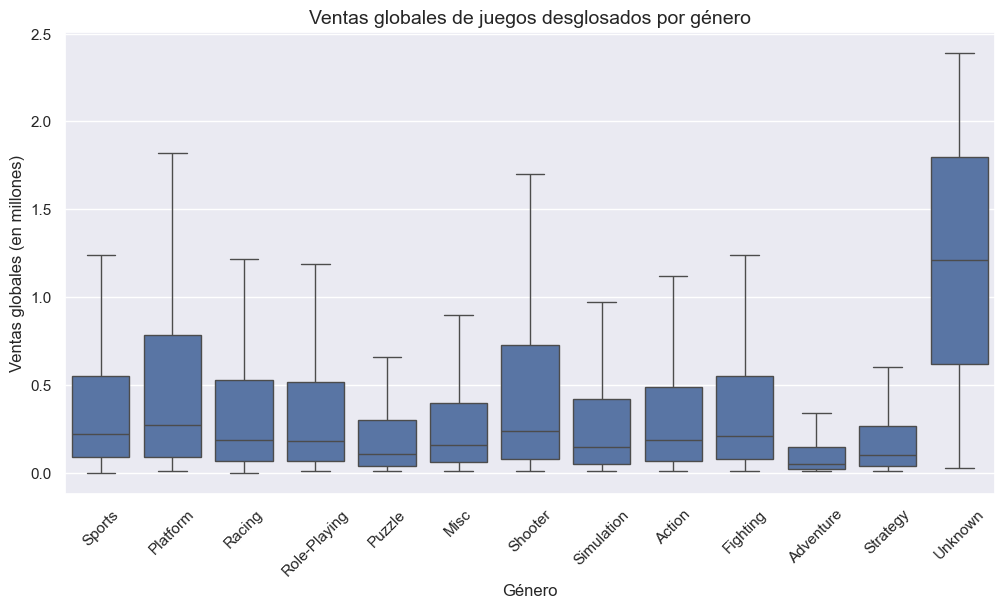

In [241]:
# Suponiendo que tienes un DataFrame llamado df con las columnas 'platform' y 'global_sales'

# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Crear el diagrama de caja
sns.boxplot(data=df, x='genre', y='total_sales', showfliers=False)  # Excluir outliers para mejor visualización

# Personalizar
plt.title('Ventas globales de juegos desglosados por género', fontsize=14)
plt.xlabel('Género', fontsize=12)
plt.ylabel('Ventas globales (en millones)', fontsize=12)
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

Los juegos de plataforma suelen ser los más vendidos, lo cual se refleja en el top 5 de los juegos más populares. La mayoría de ellos pertenecen a Nintendo, conocida por ofrecer títulos familiares y de plataforma que atraen a un público amplio.

## Paso 4. Crea un perfil de usuario para cada región

Para cada región (NA, UE, JP) determina:

Las cinco plataformas principales. Describe las variaciones en sus cuotas de mercado de una región a otra.
Los cinco géneros principales. Explica la diferencia.
Si las clasificaciones de ESRB afectan a las ventas en regiones individuales.

In [242]:
#Las cinco plataformas principales
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    top_platforms = df.groupby('platform')[region].sum().sort_values(ascending=False).head(5)
    print(f"Top 5 plataformas en {region[:2].upper()}:")
    print(top_platforms / top_platforms.sum())  # Cuotas de mercado


Top 5 plataformas en NA:
platform
X360    0.244996
PS2     0.237420
Wii     0.202066
PS3     0.160014
DS      0.155504
Name: na_sales, dtype: float64
Top 5 plataformas en EU:
platform
PS2     0.239585
PS3     0.233229
X360    0.191193
Wii     0.185156
PS      0.150837
Name: eu_sales, dtype: float64
Top 5 plataformas en JP:
platform
DS      0.261339
PS      0.208124
PS2     0.207201
SNES    0.173487
3DS     0.149849
Name: jp_sales, dtype: float64


Los japoneses dominan el mercado en su mayoría con consolas como DS,3DS,PS,PS2,PS3,WII y SNES, solo en norteamérica tiene una mayor cuota de mercado XBOX al ser una consola americana.

In [243]:
#Los cinco géneros principales. Explica la diferencia.

for region in ['na_sales', 'eu_sales', 'jp_sales']:
    top_genres = df.groupby('genre')[region].sum().sort_values(ascending=False).head(5)
    print(f"Top 5 géneros en {region[:2].upper()}:")
    print(top_genres)

Top 5 géneros en NA:
genre
Action      879.01
Sports      684.43
Shooter     592.24
Platform    445.50
Misc        407.27
Name: na_sales, dtype: float64
Top 5 géneros en EU:
genre
Action     519.13
Sports     376.79
Shooter    317.34
Racing     236.51
Misc       212.74
Name: eu_sales, dtype: float64
Top 5 géneros en JP:
genre
Role-Playing    355.41
Action          161.43
Sports          135.54
Platform        130.83
Misc            108.11
Name: jp_sales, dtype: float64


El género de "acción" es el más consumido seguido por "deportes" y "role-playing".

In [244]:
#evaluar si las clasificaciones de ESRB afectan las ventas por región
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    rating_sales = df.groupby('rating')[region].sum().sort_values(ascending=False)
    print(f"Impacto de las clasificaciones ESRB en {region[:2].upper()}:")
    print(rating_sales / rating_sales.sum())  # Proporciones por clasificación

Impacto de las clasificaciones ESRB en NA:
rating
E       0.575931
T       0.172578
M       0.170018
E10+    0.080257
K-A     0.000582
EC      0.000348
AO      0.000286
RP      0.000000
Name: na_sales, dtype: float64
Impacto de las clasificaciones ESRB en EU:
rating
E       0.546087
M       0.199602
T       0.176119
E10+    0.077751
AO      0.000252
K-A     0.000111
EC      0.000045
RP      0.000033
Name: eu_sales, dtype: float64
Impacto de las clasificaciones ESRB en JP:
rating
E       0.801676
T       0.116698
M       0.049516
E10+    0.030986
K-A     0.001125
AO      0.000000
EC      0.000000
RP      0.000000
Name: jp_sales, dtype: float64


Los juegos con clasificación "E" son los más vendidos por su contenido apto para todas las edades y público en general.

## Paso 5. Prueba las siguientes hipótesis:

Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.

In [245]:
#calificaciones promedio de Xbox One
xbox = df.query("platform == 'XOne'")
calificaciones_xbox = xbox['user_score']
#calificaciones promedio de PC
pc = df.query("platform == 'PC'")
calificaciones_pc = pc['user_score']

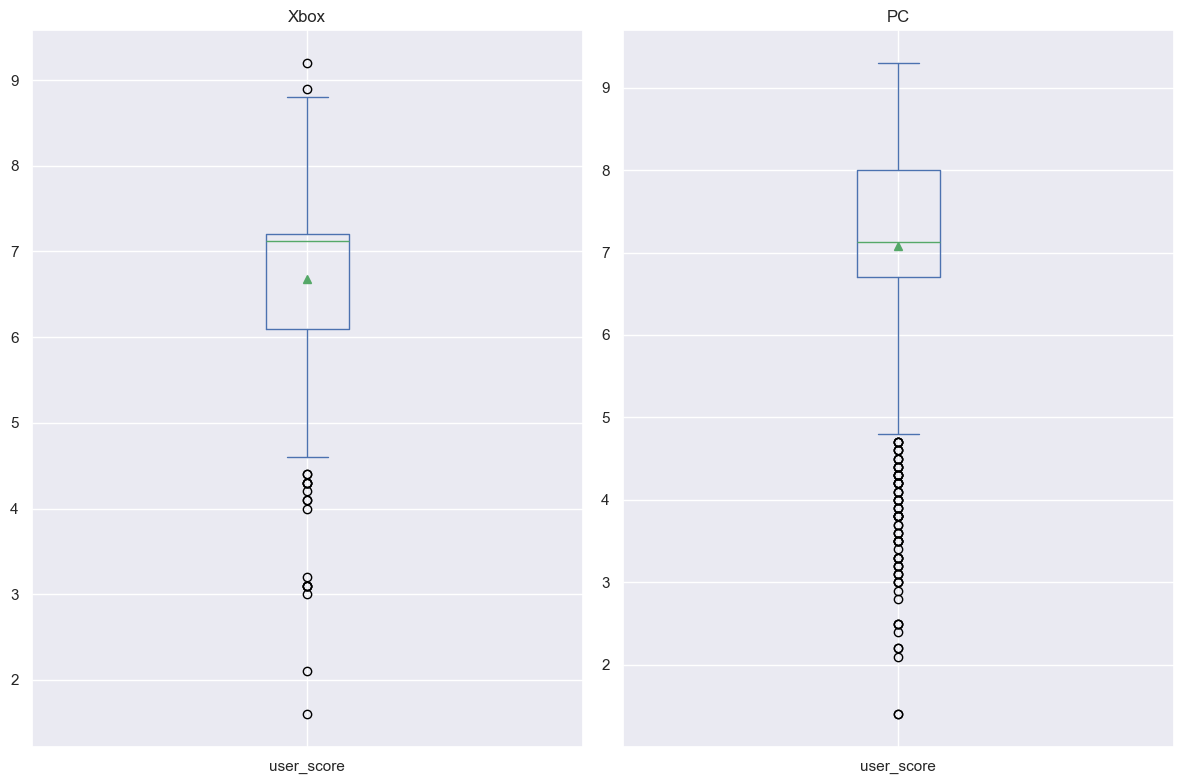

In [246]:
# Crear un lienzo con dos subgráficos
fig, axes = plt.subplots(1, 2, figsize=(12, 8))  # 1 fila, 2 columnas

# Boxplot para Xbox
calificaciones_xbox.plot(kind='box', ax=axes[0], showmeans=True)
axes[0].set_title('Xbox')

# Boxplot para PC
calificaciones_pc.plot(kind='box', ax=axes[1], showmeans=True)
axes[1].set_title('PC')

plt.tight_layout()
plt.show()

Pruba de hipótesis

H0 = No hay diferencia en la media de juegos vendios entre Xbox y PC

H1 = Si hay diferencia en la media de juegos vendios entre Xbox y PC

**Motivo para usar prueba t test para dos muestras independientes:**

Las calificaciones de Xbox y PC pertenecen a dos grupos distintos y no tienen relación entre sí (es decir, los datos son independientes). Por lo tanto, sus varianzas también se tratan como independientes. La hipótesis nula se formula bajo la premisa de que no hay diferencia significativa entre las medias de ambos grupos.

In [247]:
#prueba t para muestras independientes y con varianzas diferentes 
xbox_vs_pc_user_score = st.ttest_ind(calificaciones_xbox,calificaciones_pc, equal_var = False)

#significancia 
alpha = 0.05 
#impresión de p-valor
print(xbox_vs_pc_user_score.pvalue)

#impresión de resultados
if xbox_vs_pc_user_score.pvalue < alpha:
    print('Rechazamos la hipótesis nula')
else:
    print('No podemos rechazar la hipótesis nula')

1.0718459399074417e-05
Rechazamos la hipótesis nula


Sus medias son distintas como se observa en en el gráfico y en la prueba t para dos muestras independientes.

**Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.**

In [248]:
#calificaciones promedio de acción
accion = df.query("genre == 'Action'")
calificaciones_accion = accion['user_score']
#calificaciones promedio de PC
deportes = df.query("genre == 'Sports'")
calificaciones_deportes = deportes['user_score']

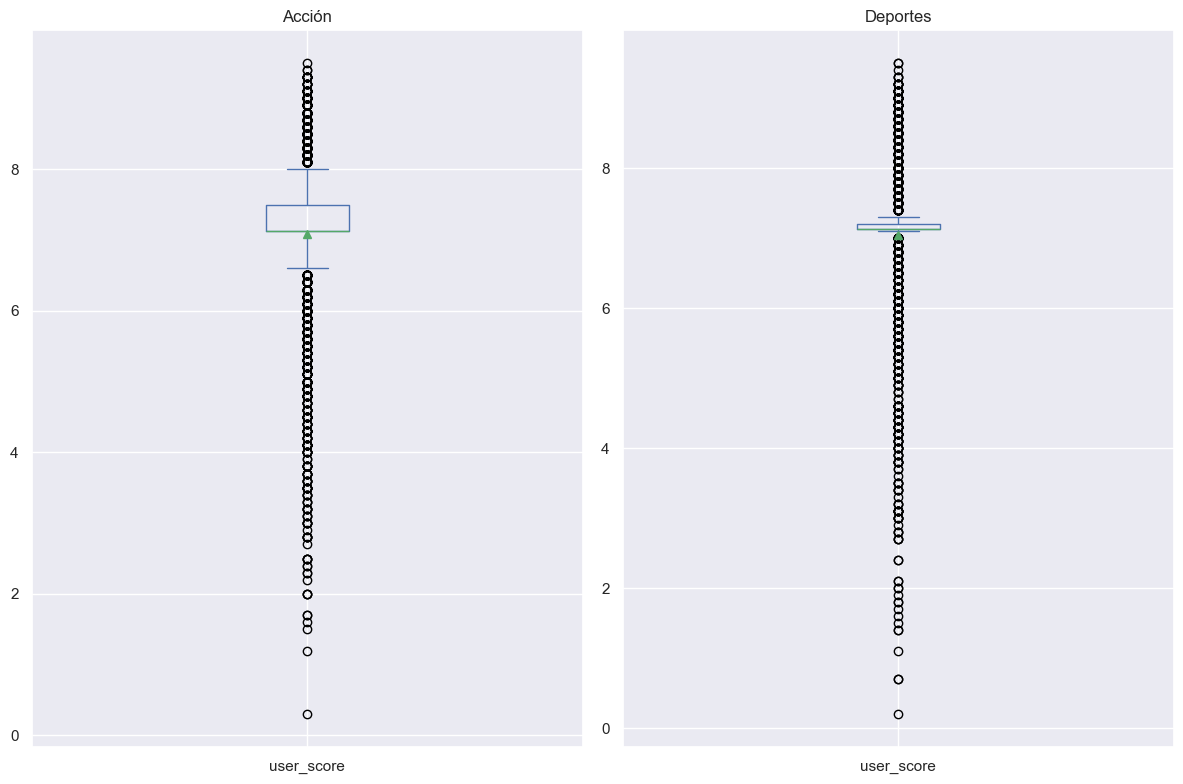

In [249]:
# Crear un lienzo con dos subgráficos
fig, axes = plt.subplots(1, 2, figsize=(12, 8))  # 1 fila, 2 columnas

# Boxplot para Xbox
calificaciones_accion.plot(kind='box', ax=axes[0], showmeans=True)
axes[0].set_title('Acción')

# Boxplot para PC
calificaciones_deportes.plot(kind='box', ax=axes[1], showmeans=True)
axes[1].set_title('Deportes')

plt.tight_layout()
plt.show()

**Motivo para usar prueba t test para dos muestras independientes:**

Al igual que las calificaciones de Xbox y PC, los generos: acción y deportes no tienen relación entre sí, por lo que se les dará el mismo tratamiento que los datos anteriores en las pruebas de hipótesis.

Pruba de hipótesis

H0 = No hay diferencia en las calificaciones promedio de los usuarios para los géneros de Acción y Deportes.

H1 = Si hay diferencia en las calificaciones promedio de los usuarios para los géneros de Acción y Deportes.

In [250]:
#prueba t para muestras independientes y con varianzas diferentes 
accion_vs_deportes = st.ttest_ind(calificaciones_accion,calificaciones_deportes, equal_var = False)

#significancia 
alpha = 0.05 
#Impresión de p-valor
print(accion_vs_deportes.pvalue)

#impresión de resultados
if accion_vs_deportes.pvalue < alpha:
    print('Rechazamos la hipótesis nula')
else:
    print('No podemos rechazar la hipótesis nula')


0.18782272416195633
No podemos rechazar la hipótesis nula


No podemos rechazar que las medias de la critica en los generos de acción y deportes sean diferentes.

----

## Paso 6. Conclusión general

Este proyecto resultó muy interesante debido a que más del 50% de los datos en varios campos eran nulos. En situaciones como esta, es común aplicar técnicas de relleno basadas en modelos de regresión lineal o predicción. Sin embargo, para este caso en particular, llené los valores faltantes utilizando medidas de tendencia central como: media y moda, así como otros campos relevantes, como el año promedio de lanzamiento. En conclusión, el manejo adecuado de los valores nulos es crucial, ya que influye en la información generada. Una estrategia bien implementada no solo evita sesgos en el análisis, sino que también proporciona información valiosa y diversa para la toma de decisiones.

---